# Predict Conversions from Quotes

**Goal**: Build a model to predict whether a quote will convert to a purchase.

**Data Sources**
* MySQL records of quote details and outcome
* Paypal records of flooring samples purchases
* Mailchimp subscriber list

In [1]:
import bd_mailchimp
import bd_paypal
import bd_mysql

import pandas as pd
import numpy as np

## Load data

In [2]:
# Load mailchimp data
csv_path = '/Users/lindsay/Documents/Data Science/BrazilianDirect/csv/mailchimp/members_export_21_march_2016.csv'
mail, first_email = bd_mailchimp.process_mailchimp(csv_path)

In [3]:
# Load paypal data
csv_dir = '/Users/lindsay/Documents/Data Science/BrazilianDirect/csv/paypal/'
paypal, first_sample = bd_paypal.process_paypal(csv_dir)

In [4]:
# Load MySQL data
config_path = '/Users/lindsay/Documents/Data Science/BrazilianDirect/cfg/mysql.cfg'
con = bd_mysql.connect_bd_mysql(config_path)
df = bd_mysql.download_quote_data(con)
df = bd_mysql.pre_process_mysql(df)

## Join data

In [5]:
# merge mysql & mail chimp
df_all = pd.merge(df, mail, how='left', on='email')

# add paypal
df_all = pd.merge(df_all, paypal, how='left', on='email')

In [6]:
# Replace nan with 0
df_all['mail_chimp'] = df_all['mail_chimp'].fillna(value=0)
df_all['samples'] = df_all['samples'].fillna(value=0)

## Filter out quotes before mail chimp & samples

In [7]:
earliest_date = pd.datetime.date(max(first_email, first_sample))
df_all = df_all.loc[df_all['date_created'] >= earliest_date, :]
df_all.shape

(20821, 26)

## Drop columns that won't be used for predictions

* `quote_id`: unique identifier
* `email`: nearly unique identifier (not many repeat customers)
* `date_created`: too fine grained to use
* `days_until_needed`: transformed into a binned variable
* `ship_state`: transformed into a grouped variable for regions
* `install_subfloor`: too many missing values
* `sq_ft`: transformed into a binned variable
* `milling`: milling is perfectly correlated with `finish` (unfinished = square edge, prefinished = micro bevel)
* `year`: interested only in monthly seasonality
* `state_division`: will use the regional divisions, which have fewer categories

In [8]:
drop_cols = ['quote_id',
             'email',
             'date_created',
             'days_until_needed',
             'ship_state',
             'install_subfloor',
             'sq_ft',
             'milling',
             'year',
             'state_division']
df_all = df_all.drop(drop_cols, axis=1)

## Prepare data for sklearn

### Extract variables from data fame

In [9]:
df_all.columns

Index([u'phone_provided', u'employee_id', u'cust_price', u'retail_price',
       u'common_name', u'finish', u'grade', u'width', u'construction',
       u'days_until_needed_bin', u'sq_ft_bin', u'converted', u'month',
       u'state_region', u'mail_chimp', u'samples'],
      dtype='object')

In [10]:
# column types
dependent_column = ['converted']
cat_columns = ['phone_provided',
               'employee_id',
               'common_name',
               'finish',
               'grade', 
               'width', 
               'construction',
               'days_until_needed_bin',
               'sq_ft_bin',
               'month', 
               'state_region',
               'mail_chimp',
               'samples']
meas_columns = ['cust_price',
                'retail_price']

In [70]:
# Extract variables
y = df_all.as_matrix(columns=dependent_column).ravel()
x_cat = df_all.as_matrix(columns=cat_columns)
x_meas = df_all.as_matrix(columns=meas_columns)

### Transform categorical variables to 0-indexed integers

In [12]:
from sklearn.preprocessing import LabelEncoder
labels = {}
for i, col in enumerate(cat_columns):
    
    # Extract the column values and convert to 0-indexed integers
    x = x_cat[:, i]
    le = LabelEncoder().fit(x)
    x_cat[:, i] = le.transform(x)
    
    # Store label data
    labels[col] = le

//anaconda/lib/python2.7/site-packages/numpy/lib/arraysetops.py:200: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))
//anaconda/lib/python2.7/site-packages/numpy/lib/arraysetops.py:259: FutureWarning: numpy equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  return aux[:-1][aux[1:] == aux[:-1]]


### Impute missing values
We'll impute with the median value for the numerical columns that are missing data (`cust_price`) and impute with the mode value for missing categorical data (`days_until_needed_bin` and `sq_ft_bin`).

In [15]:
from sklearn.preprocessing import Imputer

In [16]:
# Examine number of missing values in each column
for col in df_all.columns:
    print col, ': ', df_all[col].isnull().sum()

phone_provided :  0
employee_id :  0
cust_price :  842
retail_price :  688
common_name :  0
finish :  0
grade :  0
width :  0
construction :  0
days_until_needed_bin :  10174
sq_ft_bin :  3
converted :  0
month :  0
state_region :  0
mail_chimp :  0
samples :  0


In [17]:
# Impute measured variables
imp_meas = Imputer(missing_values=np.nan, strategy='median', axis=0)

# Fit imputer
imp_meas.fit(x_meas)

# Impute values
x_meas_imp = imp_meas.transform(x_meas)

In [21]:
# Impute categorical variables
imp_cat = Imputer(missing_values=np.nan, strategy='most_frequent', axis=0)

# Fit imputer
imp_cat.fit(x_cat)

# Impute values
x_cat_imp = imp_cat.transform(x_cat)

### Perform one-hot encoding on categorical variables

In [23]:
from sklearn.preprocessing import OneHotEncoder

In [24]:
# Use one-hot encoding to transform categorical variable into
# multiple binary variables
enc = OneHotEncoder()
enc.fit(x_cat_imp)

# Apply one-hot encoding
x_cat_imp = enc.transform(x_cat_imp).toarray()

In [33]:
# Create a list so we know what the one-hot encoded columns refer to
one_hot_columns = []
for col in cat_columns:
    features = list(labels[col].classes_)
    for f in features:
        one_hot_columns.append(col + '_' + str(f))

### Scale continuous features

In [35]:
from sklearn.preprocessing import scale
x_meas_imp = scale(x_meas_imp)

### Concatenate categorical and continuous features

In [37]:
x = np.concatenate((x_cat_imp, x_meas_imp), axis=1)
x_names = one_hot_columns + meas_columns

## Logistic Regression

In [39]:
from sklearn.linear_model import LogisticRegressionCV

In [40]:
from sklearn.metrics import f1_score

In [100]:
c = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
lr = LogisticRegressionCV(class_weight='balanced', 
                          scoring='average_precision',
                          Cs=c,
                          cv=10)
lr

LogisticRegressionCV(Cs=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
           class_weight='balanced', cv=10, dual=False, fit_intercept=True,
           intercept_scaling=1.0, max_iter=100, multi_class='ovr',
           n_jobs=1, penalty='l2', random_state=None, refit=True,
           scoring='average_precision', solver='lbfgs', tol=0.0001,
           verbose=0)

In [101]:
lr = lr.fit(x, y)

In [102]:
lr.coef_

array([[-0.28596265,  0.28595905,  0.07460258,  0.02144461, -0.1623039 ,
         0.06625311,  0.0432307 , -0.06283856,  0.05041167, -0.05847393,
        -0.02640949,  0.01249368,  0.04512746,  0.08056245, -0.0841076 ,
        -0.02109784, -0.04115682,  0.06225105, -0.05717751,  0.01532117,
        -0.00113039,  0.04298314, -0.00135473,  0.05884321,  0.03275145,
        -0.06135874,  0.04821791, -0.07710269, -0.03050627, -0.00831092,
         0.03881359,  0.1566717 , -0.08094491, -0.03949624,  0.05261838,
        -0.08885253,  0.00255546,  0.02798396,  0.03206615, -0.02804292,
         0.00036489, -0.03378837, -0.00114277, -0.02124431, -0.05217767,
         0.00084033, -0.00607577,  0.01945987, -0.00598102,  0.0135713 ,
        -0.03030499,  0.01584463,  0.01238716,  0.03247149,  0.02120538,
        -0.14561727,  0.00150676,  0.18503027,  0.02491219, -0.06583555,
        -0.12374915,  0.12374555, -0.32732683,  0.32732323, -0.08818736,
         0.12511332]])

In [103]:
feature_order = list(np.argsort(np.abs(lr.coef_[0]))[::-1])

In [104]:
for feature in feature_order:
    if lr.coef_[0][feature] > 0:
        weight = 'pos'
    else:
        weight = 'neg'
    
    print weight, ' - ', x_names[feature]

neg  -  samples_0.0
pos  -  samples_1.0
neg  -  phone_provided_0
pos  -  phone_provided_1
pos  -  state_region_northeast
neg  -  employee_id_OTHER
pos  -  days_until_needed_bin_nan
neg  -  state_region_Other
pos  -  retail_price
neg  -  mail_chimp_0.0
pos  -  mail_chimp_1.0
neg  -  days_until_needed_bin_91+
neg  -  cust_price
neg  -  common_name_Tigerwood
neg  -  days_until_needed_bin_0-30
pos  -  common_name_Tiete Rosewood
neg  -  width_Other
pos  -  employee_id_DC
pos  -  employee_id_SO
neg  -  state_region_west
neg  -  common_name_Brazilian Cherry
pos  -  finish_Unfinished
neg  -  width_4 3/4
pos  -  width_3 1/4
neg  -  common_name_Brazilian Walnut
neg  -  grade_Clear
pos  -  days_until_needed_bin_61-90
neg  -  month_2.0
pos  -  common_name_Brazilian Teak
pos  -  width_5
pos  -  common_name_Santos Mahogany
pos  -  common_name_Amendoim
pos  -  grade_Select & Better
neg  -  finish_Prefinished
neg  -  days_until_needed_bin_31-60
pos  -  construction_Solid
neg  -  sq_ft_bin_5001+
pos  -

In [109]:
lr.scores_

{1: array([[ 0.12217009,  0.12510245,  0.12954251,  0.13122185,  0.13100243,
          0.13086346,  0.13070382,  0.13070211,  0.13070122],
        [ 0.16400321,  0.1731583 ,  0.17356398,  0.17428575,  0.17404293,
          0.17419563,  0.17419531,  0.17422919,  0.17421939],
        [ 0.16245601,  0.165136  ,  0.16300537,  0.15985777,  0.15432829,
          0.15419988,  0.1542084 ,  0.15420298,  0.15420462],
        [ 0.14691294,  0.14375442,  0.1316308 ,  0.12735778,  0.12696433,
          0.12694485,  0.12694617,  0.1269484 ,  0.1269484 ],
        [ 0.186845  ,  0.18752846,  0.17335337,  0.16588318,  0.16412377,
          0.16400972,  0.16396604,  0.16396545,  0.16395722],
        [ 0.12697488,  0.13692581,  0.14342135,  0.14550258,  0.1459505 ,
          0.14623612,  0.1462338 ,  0.14623589,  0.14623356],
        [ 0.13652361,  0.14001409,  0.13779681,  0.13426573,  0.13308897,
          0.13282992,  0.13250847,  0.1325014 ,  0.1325027 ],
        [ 0.12355228,  0.13421198,  0.1388938

## Random Forest

In [110]:
from sklearn.ensemble import RandomForestClassifier

In [114]:
rfc = RandomForestClassifier(n_estimators = 10, 
                             max_features = 'sqrt', 
                             class_weight = 'balanced',
                             oob_score = True)

In [115]:
param_grid = {
    'n_estimators': [32, 64, 128, 256, 512],
    'max_features': ['auto', 'log2', None]
}

In [116]:
from sklearn.grid_search import GridSearchCV

In [117]:
CV_rfc = GridSearchCV(estimator = rfc, param_grid=param_grid, cv=10)
CV_rfc.fit(x, y)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='sqrt',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [32, 64, 128, 256, 512], 'max_features': ['auto', 'log2', None]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [118]:
CV_rfc.best_params_

{'max_features': 'log2', 'n_estimators': 64}

In [122]:
rfc = RandomForestClassifier(n_estimators = 64,
                             max_features = 'log2',
                             class_weight = 'balanced',
                             oob_score = True)

In [123]:
from sklearn.cross_validation import train_test_split

In [124]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.33, stratify=y)

In [143]:
rfc = rfc.fit(x_train, y_train)

In [144]:
y_pred = rfc.predict(x_test)

In [145]:
pd.crosstab(y_pred, y_test)

col_0,0,1
row_0,,
0,6337,501
1,26,7


In [148]:
import seaborn as sns
sns.set;
%matplotlib inline

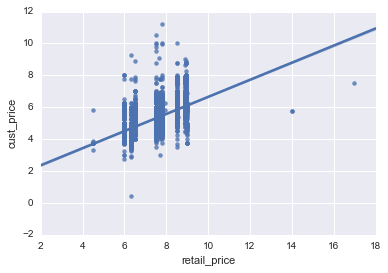

In [149]:
sns.regplot(x=df_all['retail_price'], y = df_all['cust_price']);

In [150]:
pd.crosstab(df_all['converted'], [df_all['phone_provided'], df_all['samples']])

phone_provided      0          1     
samples           0.0  1.0   0.0  1.0
converted                            
0               11399  841  6426  616
1                 494  165   703  177

In [153]:
177./(177+616)

0.223203026481715

In [154]:
703./(703+6426)

0.09861130593351101

In [155]:
abs(-1)x

1